In [30]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [31]:
format_converter_to_tensor = transforms.ToTensor()

get_dataset_train = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=format_converter_to_tensor)
buffer_dataset_train = torch.utils.data.DataLoader(get_dataset_train, batch_size=64, shuffle=True)

get_dataset_value = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=format_converter_to_tensor)
buffer_dataset_value = torch.utils.data.DataLoader(get_dataset_value, batch_size=64, shuffle=True)

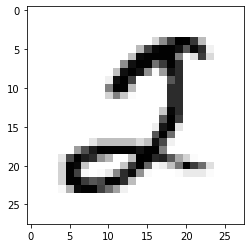

In [32]:
datareader_train = iter(buffer_dataset_train)

imagens, etiquetas = datareader_train.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [33]:
print(imagens[0].shape)

print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [34]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return F.log_softmax(x, dim=1)

In [35]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = time()

  criterio = nn.NLLLoss()
  EPOCHS = 30
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1)
      otimizador.zero_grad()

      output = modelo(imagens.to(device))
      perda_instantanea = criterio(output, etiquetas.to(device))

      perda_instantanea.backward()

      otimizador.step()

      perda_acumulada += perda_instantanea.item()

  print('Tempo de treino (min) = ', (time()-inicio)/60)

In [40]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1,784)

      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if (etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print(f'Total de imagens testadas = {conta_todas}')
  print('Precisão do modelo = {}%'.format(conta_corretas*100/conta_todas))

In [37]:
modelo = Modelo()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [38]:
treino(modelo, buffer_dataset_train, device)

Tempo de treino (min) =  4.118900644779205


In [41]:
validacao(modelo, buffer_dataset_value, device)

Total de imagens testadas = 10000
Precisão do modelo = 97.45%
